In [1]:
using Multitaper, Plots, DelimitedFiles, Statistics, StatsBase, LinearAlgebra, Distributions, 
      LombScargle, FINUFFT, LaTeXStrings

mdmultispec_noadapt (generic function with 1 method)

# Demo of the missing-data multitaper power spectrum estimator from  [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract) section 3

### Mathematical method by [Chave (2019)](https://academic.oup.com/gji/article/218/3/2165/5519233?login=false)

This demo uses <em>Kepler</em> Q16 observations of the rotational variable star KIC 6102338.

For help understanding file-reading and plotting commands, check out [Julia quickstart for astronomers](https://github.com/lootie/Multitaper.jl/blob/master/Julia_quickstart/Julia_quickstart_astronomers.ipynb)

### Read data file, shift timestamps so t0 = 0

In [2]:
Kep16 = readdlm("KIC6102338_Q16.txt", comments=true)
BJD16 = Kep16[:,1]
flux16 = Kep16[:,2]
time16 = BJD16 .- BJD16[1]

3534-element Vector{Float64}:
  0.0
  0.020433288998901844
  0.04086637822911143
  0.06129966815933585
  0.0817328579723835
  0.10216594813391566
  0.12259923852980137
  0.14303242973983288
  0.16346552083268762
  0.1838988121598959
  0.2043320038355887
  0.22476519597694278
  0.24519838858395815
  ⋮
 85.59735131403431
 85.61778568476439
 85.65865442622453
 85.6790887969546
 85.69952306849882
 85.71995753981173
 85.74039191100746
 85.76082628266886
 85.78126065433025
 85.80169492634013
 85.82212939858437
 85.84256377071142

### Plot the fluxes

In the paper, this is the top panel of Figure 5

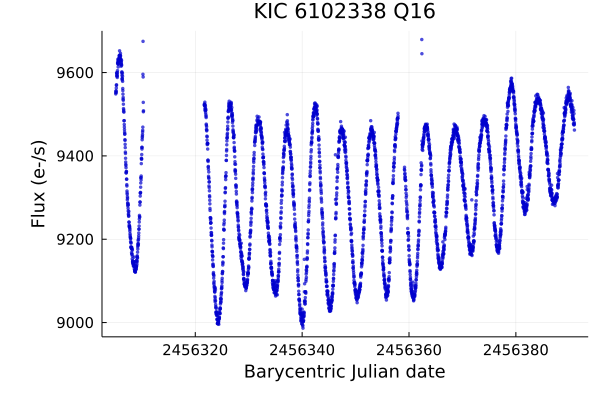

In [3]:
pflux16 = scatter(BJD16, flux16, xlabel="Barycentric Julian date", ylabel="Flux (e-/s)", 
                 legend=false, xtickfontsize=10, left_margin = 8Plots.mm, xguidefontsize=12, 
                 ytickfontsize=10, yguidefontsize=12, msw=0, title="KIC 6102338 Q16", ma=0.7, 
                 ms=2, bottom_margin = 5Plots.mm, color=:mediumblue)

### Examine the timesteps

The effects of gaps become obvious in both the maximum and mean timestep.

In [4]:
dt16 = diff(time16)
dt = median(dt16)

println(dt)
println(mean(dt16))
println(maximum(dt16))
println(minimum(dt16))

0.020433960016816854
0.02429735742165622
11.381376679521054
0.02043308923020959


### Create a vector of scaled timestamps that have integer values and $\Delta t = 1$

Solving the eigenvalue problem that calculates the Chave tapers requires this type of grid. 

In [5]:
tscale16 = round.(time16 ./ dt)

3534-element Vector{Float64}:
    0.0
    1.0
    2.0
    3.0
    4.0
    5.0
    6.0
    7.0
    8.0
    9.0
   10.0
   11.0
   12.0
    ⋮
 4189.0
 4190.0
 4192.0
 4193.0
 4194.0
 4195.0
 4196.0
 4197.0
 4198.0
 4199.0
 4200.0
 4201.0

### Make a histogram of the deviations of the scaled timesteps from unity

Verify that the deviations are small so we can assume uniform time sampling 

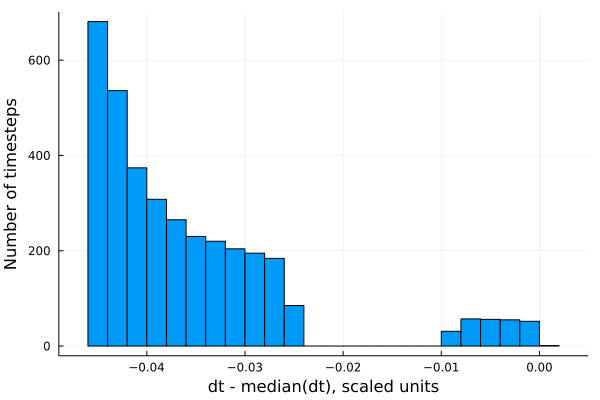

In [6]:
tscale16_check = histogram((time16 ./ dt) .- tscale16, xlabel="dt - median(dt), scaled units",
                            ylabel="Number of timesteps", label=false)

### Calculate the missing-data Slepian sequences according to [Chave (2019)](https://academic.oup.com/gji/article/218/3/2165/5519233?login=false)

Syntax of the call to <tt>mdslepian()</tt> (short for missing-data Slepian sequences):
<ul>
    <li>The first argument is the SCALED bandwidth in units where the Nyquist frequency is 0.5, denoted $\varpi$ in <a href="https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract">Dodson-Robinson & Haley (2024)</a>. See section 2.7 for tips on choosing the bandwidth. A good starting point is often $N\varpi = 4, \varpi = N\varpi / N$. The bandwidth in physical units is $\tilde{\varpi} = \varpi / \Delta t$.</li>
    <li>The second argument is the number of tapers $K$.</li>
    <li>The third argument is the vector of INTEGER time indices $t = t_0, t_1, t_2, \ldots, t_{N-1}$ with rescaled $\Delta t = 1$ except where there are gaps.</li>
<ul>

In [7]:
NW  = 4
K   = 6
N16 = length(time16)
W16 = NW / N16
lam16, sleps16 = mdslepian(W16, K, tscale16)

([0.9878822757965026, 0.9873672652093293, 0.9832152921677377, 0.9776770084442815, 0.9647243114278039, 0.8994723349445644], [4.8470904867141396e-5 0.00041986380387064315 … 0.0023335376402043423 0.005338119042034451; 4.819825964086366e-5 0.00042358236291398926 … 0.002348510980484642 0.005344550047128969; … ; -0.0005632690434388601 -0.00039947551354520446 … -0.006168354573383376 0.01886298846950582; -0.0005607375008641145 -0.00040149332293052883 … -0.0061140667855217115 0.018761442932177696])

### Identify the large gaps, print out bandwidth in scaled and physical units

In [8]:
gaps = findall(dt16 .> 3*median(dt16))
println(gaps)
println("Scaled bandwidth: ", W16)
println("True bandwidth (1/day): ", W16 / median(dt))

[252, 707, 731, 1999]
Scaled bandwidth: 0.0011318619128466328
True bandwidth (1/day): 0.05539121696994252


### Code to plot the tapers

In our call to <tt>plot()</tt>, we are making use of the fact that you can pass in an array of size <tt>(nrows, ncolumns) = (length(x), number_of_series)</tt> as the y-value argument and <tt>Plots.jl</tt> will automatically treat each column as a separate series to be plotted. Here we want each taper to be a series on the plot, so <tt>number_of_series</tt> = $K = 6$.

A weird quirk of <tt>Plots.jl</tt> is that the double-loop that adds the gap shading prevents the plot from displaying in this cell. It will show up as the bottom of a two-panel plot in the next cell, but if you want to display it here, add <br />
<tt>plot(psleps16)</tt><br />
to the bottom of this cell.

In [9]:
lw = [2 2 3 2]
ls = [:solid :dash :dot :dashdot]

psleps16 = plot(BJD16, sleps16, xlabel="Barycentric Julian date", ylabel=L"w_n^{(k)}", 
                title=L"\operatorname{MDSS}: \; K=6, \; N\varpi = 4", xtickfontsize=10, 
                left_margin = 8Plots.mm, ls=ls, lw=lw, xguidefontsize=12, ytickfontsize=10, 
                yguidefontsize=16, legendfontsize=8, titlefontsize=14, wsize=(900,500), 
                bottom_margin = 5Plots.mm, labels=round.(lam16, digits=4)',
                legend_position=(0.9,1.2))

for i in 1:length(gaps)
    for j in 1:K
        plot!([BJD16[gaps[i]], BJD16[gaps[i]+1]], [-0.05, -0.05], fillrange=[0.05, 0.05], lw=4, 
               color=:lightgray, label=false)
    end
end

Figure 5 of [Dodson-Robinson & Haley (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....167...22D/abstract)

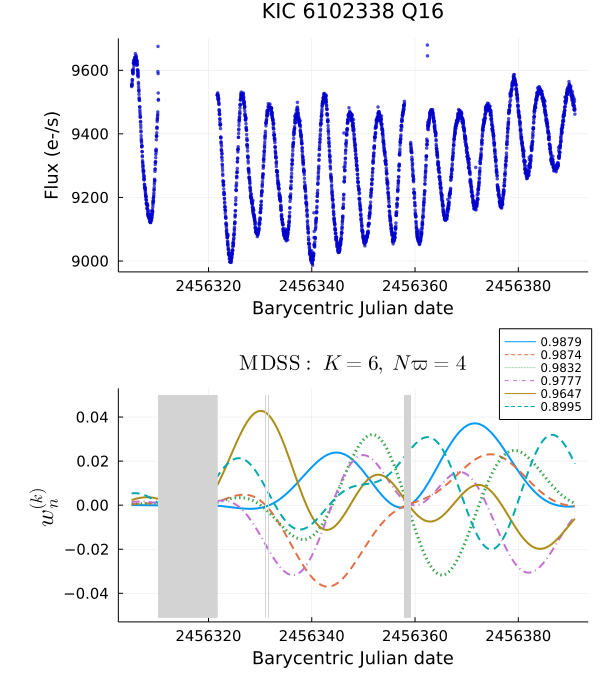

In [10]:
plot(pflux16, psleps16, layout=(2,1), wsize=(600,700))

### Compute the multitaper power spectrum estimate

Syntax of the call to <tt>mdmultispec_noadapt()</tt> (missing-data multitaper power spectrum estimate without adaptive weighting):<br />
<ul>
    <li>The first argument is the vector of INTEGER time indices $t = t_0, t_1, t_2, \ldots, t_{N-1}$. We have to pass in the time indices so the software will know where the gaps are.</li>
    <li>The second argument is the vector of observations. Although <tt>Multitaper.jl</tt> will subtract off the time series mean, I have deliberately ingrained the habit of zero-meaning my data anytime I'm doing Fourier analysis.</li>
    <li><tt>bw</tt> is the bandwidth in SCALED units where $\Delta t = 1$ and the Nyquist frequency is 0.5. The default is given by $N\varpi = 5, \varpi = N\varpi / N$.</li>
    <li><tt>k</tt> is the number of tapers. The default is <tt>floor</tt>$(2N\varpi)$.</li>
    <li><tt>nz</tt> tells the software what factor to use in padding the time-domain data / oversampling the frequency grid. The native (Rayleigh) resolution of a power spectrum estimate is $1 / (t_{N-1} - t_0)$, which gives an equal number of frequency gridpoints as observations if the time grid is evenly spaced. Your frequency grid will have length <tt>nz</tt>$\times N$. Equivalent to <tt>samples_per_peak</tt> in <tt>astropy.timeseries.LombScargle</tt>.</li>
        <li>If the physical time interval between observations is something other than 1, pass that in using the <tt>dt</tt> keyword.</li>
</ul>

Defaults are to perform the F-test (<tt>Ftest = true</tt>) and calculate jackknife confidence intervals (<tt>jk = true</tt>). You can turn off either of these calculations with <tt>Ftest = false</tt> and <tt>jk = false</tt>.</li>

The output of <tt>mdmultispec_noadapt()</tt> is a tuple. First in the tuple is a structure of type <tt>MTSpectrum</tt> defined in [<tt>StructsTypes.jl</tt>](https://github.com/lootie/Multitaper.jl/blob/master/src/StructsTypes.jl). In cells 15 and 16, we directly access the structure fields for frequency (<tt>.f</tt>) and p-value given by the F-test at each frequency (<tt>.Fpval</tt>). The spectrum is in field <tt>.S</tt>. Second in the tuple is the degrees of freedom $\nu$, which we will not need here.

See the [<tt>Examples</tt>](https://github.com/lootie/Multitaper.jl/blob/master/Examples/01_basic_multitaper.ipynb) directory for more power spectrum estimates.

In [11]:
multispec16, nu = mdmultispec_noadapt(tscale16, flux16 .- mean(flux16), bw=W16, 
                                      k=K, nz=2, dt=dt)

(MTSpectrum{EigenCoefficient, Vector{Float64}, Nothing}(0.0:0.00461593474749521:24.46907009647211, [16084.897986171824, 33479.60918297595, 36125.43738882205, 36325.08661808619, 36890.0767542617, 37951.00861956554, 32881.92511143989, 28636.978129848736, 26543.871247213476, 19344.52088946529  …  5.1731599227420775, 5.04385154576351, 4.492225256214471, 3.7525054070560584, 3.5340365760908203, 3.541911089362569, 3.0257770758449314, 2.2518281638486104, 1.6988905018279636, 0.7408528357445759], nothing, MTParameters(4.0, 6, 3534, 1.0, 10602, 1, nothing), EigenCoefficient(ComplexF64[-15.14451275467007 - 7.126177563533918e-14im 1415.1431203271786 - 1.3165396008357527e-13im … -1272.8063837881846 + 2.4752989487588247e-13im 235.15705462456464 - 2.795714755921871e-13im; -501.40011655583805 + 41.67069148953093im 99.95913622493656 - 1241.1138250773677im … -15.091007369559074 + 891.160098985348im -747.1430490305453 - 6.197602613031027im; … ; 2.5395938466202748 - 6.434430840776225im 2.4849862610760836 -

### Calculate the spectral windows of the MDSS tapers

In [12]:
oversample = 8 # Just to make a pretty plot

fgrid16 = collect(LinRange(1/N16/oversample, 24, oversample*N16))
specwin16 = zeros((oversample*N16, K)) 
for k in 1:K
    specwin16[:,k] = abs2.(nufft1d3(2 .* pi .* time16, ComplexF64.(sleps16[:,k]), -1, 1e-15, fgrid16))'
end

### Plot the spectral windows

This is Figure 6. Once again, we are making use of the fact that <tt>Plots.jl</tt> will treat each column of an array in the y argument as a separate series.

In [13]:
lw = [2 3 2 3]
ls = [:dashdot :solid :dash :dot :dashdot :solid]
colors = [:goldenrod :green :darkorchid :firebrick :brown :dodgerblue]

pmdssw = plot(fgrid16, specwin16[:,1:end], label = round.(lam16[1:end], digits=4)', yscale = :log10, xscale = :log10, ls=ls, color=colors,
              xlabel = L"\operatorname{Frequency} \; (\operatorname{day}^{-1})", left_margin=5Plots.mm,
              title = "MDSS spectral windows", xlim=(0.001,1), lw=lw, right_margin=5Plots.mm, 
              ylabel = L"W^{(k)}(f)", xtickfontsize=12, ytickfontsize=12, xguidefontsize=14, yguidefontsize=14, 
              legendfontsize=10, legend=:left, bottom_margin=8Plots.mm, ylim=(1e-5,3e3),
              yticks=[1e-5, 1e-3, 0.1, 10, 1e3])

pmdssw = annotate!(7.7e-3, 5e-5, L"\varpi = 0.001132")
pmdssw = annotate!(1.1e-2, 3e-4, L"\tilde{\varpi} = 0.05539 \; \operatorname{day}^{-1}")

pmdssw = plot!([W16/dt, W16/dt], [1e-5, 3e3], label=false, line = :dash, color=:black, lw=2)

# savefig("Kepler_Q16_spectral_windows.png")

### Calculate the Lomb-Scargle periodogram

In [14]:
LS16 = lombscargle(time16, flux16, nyquist_factor=1, normalization=:psd, samples_per_peak=2)
fls16, Pls16 = freqpower(LS16)

(0.0029123081722926985:0.005824616344585397:20.5812818535925, [6.99032325343292e6, 6.679463245995663e6, 4.403029627675911e6, 610597.4820161542, 1.3342772390324124e6, 157426.6763479074, 482374.79511337774, 25695.753508607548, 208918.44147425285, 84215.03299589513  …  497.154908613373, 0.731048402251351, 279.2391102726661, 130.20657225775997, 187.93722751668776, 297.38347589354623, 24.758118616640367, 383.342037210278, 1846.1577012505554, 1846.1838639344655])

### Identify signals significant at the 1-1/N level (FAP < 1/N) in the multitaper power spectrum estimate

With a false alarm probability threshold of 1/N, we expect roughly 1 F-test false alarm per power spectrum estimate. This is the stringent criterion recommended by [Thomson (1990)](https://ui.adsabs.harvard.edu/abs/1990RSPTA.332..539T/abstract).

In [15]:
threshold = 1/N16
Q16Pks = findall(multispec16.Fpval .< threshold)

7-element Vector{Int64}:
   42
   43
   84
   85
 2295
 4022
 4581

### Plot the multitaper power spectrum estimate

<tt>Multitaper.jl</tt> has a plot recipe for structures of type <tt>MTSpectrum</tt>. It automatically overlays the confidence interval on the power spectrum estimate.

By default, the plot recipe puts the labels "Frequency" on the x-axis and "Spectrum" on the y-axis. Both are overridden here. I put in an empty x-axis label using <tt>xlabel=" "</tt> because this panel will be on top of a three-panel figure, and I only want the x-axis label on the bottom panel.

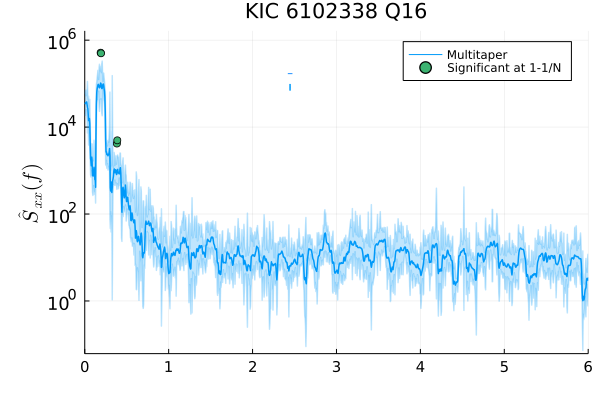

In [16]:
Q16specplot_zoom = plot(multispec16, xlabel=" ", ylabel=L"\hat{S}_{xx}(f)", label="Multitaper", 
                        title="KIC 6102338 Q16", lw=1.5, xtickfontsize=10, ytickfontsize=12, 
                        xlim=(0,6), yguidefontsize=14, legendfontsize=8,
                        yticks=[1e-4, 0.01, 1, 100, 1e4, 1e6], left_margin=5Plots.mm,
                        ylim=(3*dt,8e7*dt))

plot!([2.42, 2.42+W16/dt], [8.3e6*dt,8.3e6*dt], label=false, color=:dodgerblue) # horizontal cross bar

scatter!(multispec16.f[Q16Pks], 5 .* multispec16.S[Q16Pks], color=:mediumseagreen, 
         label="Significant at 1-1/N")

### Plot the F-test p-value

Middle plot of 3

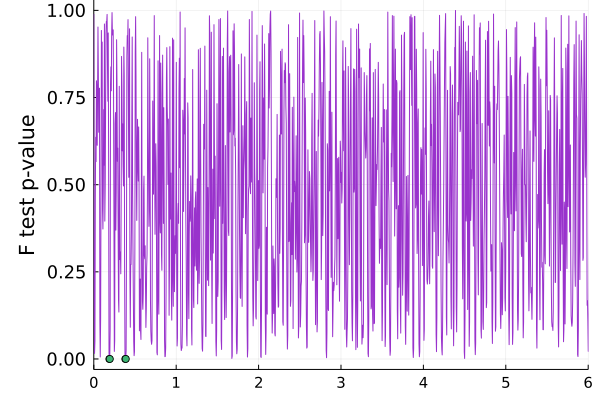

In [17]:
Fplot = plot(multispec16.f, multispec16.Fpval, ylabel="F test p-value", xtickfontsize=10, 
             ytickfontsize=12, yguidefontsize=14, label=false, color=:darkorchid,
             top_margin=-4Plots.mm, xlim=(0,6), left_margin=5Plots.mm,)

scatter!(multispec16.f[Q16Pks], multispec16.Fpval[Q16Pks], color=:mediumseagreen, label=false)

### Plot the Lomb-Scargle periodogram on top of the multitaper confidence intervals

I use <tt>Multitaper.jl</tt>'s plot recipe for structures of type <tt>MTSpectrum</tt> to plot the confidence intervals. I want to showcase the Lomb-Scargle periodogram here, so I set the linewidth to 0.2 in the plot recipe (<tt>lw=0.2</tt>) to prevent the line corresponding to the multitaper power spectrum estimate from showing up on the plot.

This is the bottom plot of three.

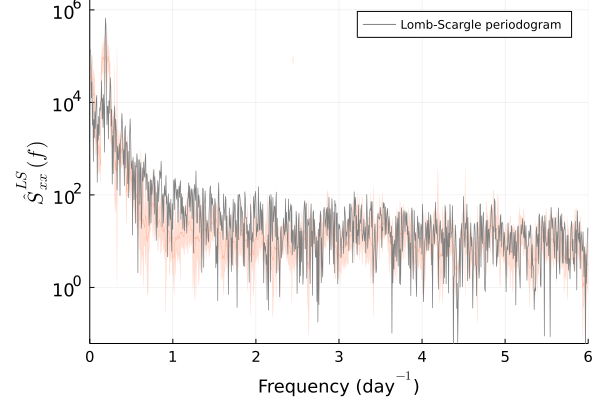

In [18]:
perplot = plot(multispec16, xlabel="Frequency (day"*L"^{-1}"*")", ylabel=L"\hat{S}^{LS}_{xx}(f)", 
               lw=0.2, xtickfontsize=10, ytickfontsize=12, xguidefontsize=12, 
               yguidefontsize=14, legendfontsize=8, bottom_margin=3Plots.mm,
               color=:coral, label=false, top_margin=-4Plots.mm, xlim=(0,6),
               left_margin=5Plots.mm, ylim=(3*dt,8e7*dt))

plot!(fls16, dt .* Pls16, lw=0.7, color=:gray, label="Lomb-Scargle periodogram")

### Combine all three plots

This is Figure 7.

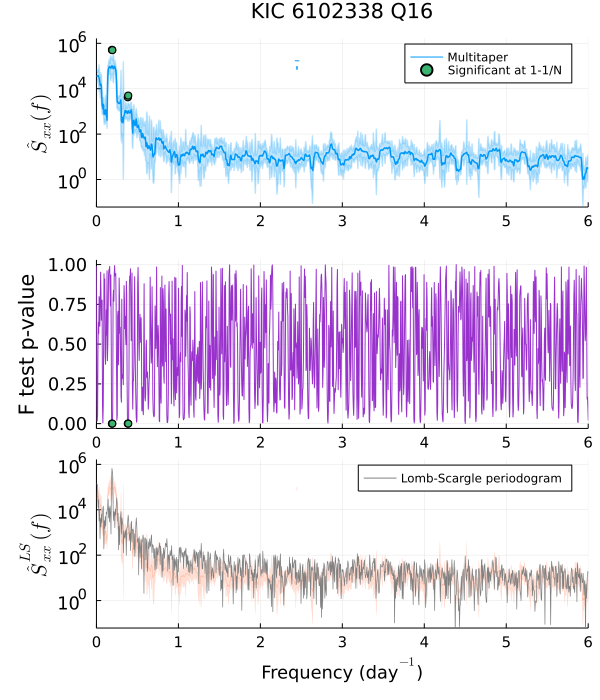

In [19]:
plot(Q16specplot_zoom, Fplot, perplot, layout=(3,1), wsize=(600,700))
# savefig("KIC6102338_Q16_spec.png")